In [5]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

%matplotlib inline

In [2]:
sst = xr.open_dataset('http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/2018/20180520152000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_night.nc')
alt = xr.open_dataset('http://thredds.aodn.org.au/thredds/dodsC/IMOS/OceanCurrent/GSLA/DM01/yearfiles/IMOS_OceanCurrent_HV_DM01_2018_C-20200616T144027Z.nc.gz')

In [3]:
sst['sst']=sst.sea_surface_temperature-273.15

/Users/lachlanphillips/miniconda3/envs/oceans/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


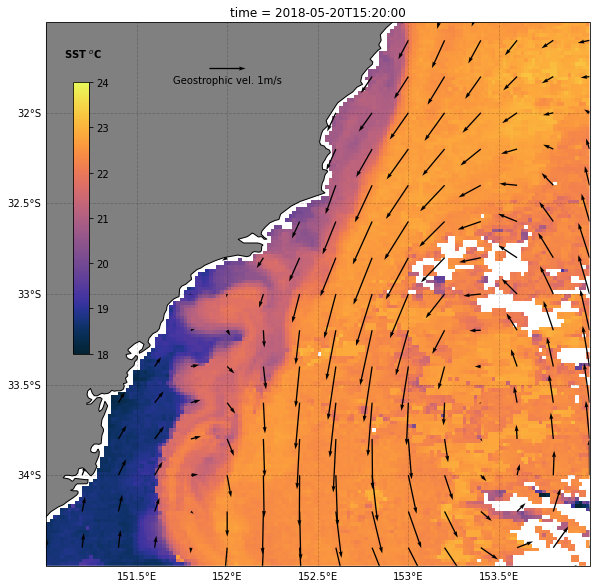

In [4]:
day='2018-05-20'

fig = plt.figure(figsize=(18,10))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im=sst.sst.plot(cmap=cmocean.cm.thermal,add_colorbar=False, vmin=18,vmax=24)
Q = plt.quiver(alt.LONGITUDE, alt.LATITUDE, alt.UCUR.sel(TIME=day), alt.VCUR.sel(TIME=day), units='width', scale=15)
ax.set_extent([151,154,-31.5,-34.5])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
plt.text(151.1,-31.7,'SST $^o$C',weight='bold')

plt.quiverkey(Q, X=152, Y=-31.75, U=1, color='black',coordinates='data',
             label='Geostrophic vel. 1m/s', labelpos='S')
# colorbar
cax = inset_axes(ax,
                 width="3%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
#plt.savefig('../../plots/Radar/NEWC_alt_2018_05_20.png',format="png",bbox_inches='tight',pad_inches=0.1, dpi=300)